In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import datetime
import matplotlib
from matplotlib import pyplot

In [2]:
import DataPrep
import error_evaluation

In [3]:
X_Above_test, X_Above_train, y_Above_test, y_Above_train, X_Near_test, X_Near_train, y_Near_test, y_Near_train, X_Below_test, X_Below_train, y_Below_test, y_Below_train = DataPrep.prep_day1_danger_train_test('../Data/V1.1FeaturesWithLabels20131201To20180430.csv', ignore_extreme=True)

In [4]:
X_Above_train.tail()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev7DayFreezeThawLikeliness9InPast,c_r_Prev3DayWindSlabLikeliness9InPast,c_r_Prev7DayWindSlabLikeliness9InPast,c_r_Prev3DayFreezeThawLikeliness10InPast,c_r_Prev7DayFreezeThawLikeliness10InPast,c_r_Prev3DayWindSlabLikeliness10InPast,c_r_Prev7DayWindSlabLikeliness10InPast,c_IsCoastalSnowpack,c_IsContenentalSnowpack,DayOfYear
169317,0.250,3.498339,0.250,2.991883,0.375,3.180753,0.625,2.986401,0.875,2.337439,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,347.0
169318,0.500,3.412153,0.750,2.453915,1.375,2.238766,2.000,1.594356,2.625,1.469435,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,347.0
169319,0.125,3.844089,0.125,3.638352,0.375,3.879538,0.500,3.780000,0.750,2.853918,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,347.0
169320,0.500,3.654338,0.750,2.830525,1.250,2.489981,1.625,1.786699,2.250,1.566147,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,347.0
169321,0.250,3.458072,0.375,2.713073,0.750,2.500116,1.125,1.872651,1.500,1.674750,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,347.0


In [5]:
y_Above_train['o_Day1DangerAboveTreeline'].value_counts()

Moderate        44376
Low             33407
Considerable    31790
High             8132
Name: o_Day1DangerAboveTreeline, dtype: int64

In [6]:

#parameters derived from a several step parameter search
grid = {'min_child_weight': 5, 'n_estimators': 250, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9, 'objective': 'multi:softmax', 'max_depth': 7}
#modelAbove = XGBClassifier(tree_method='gpu_hist', n_jobs=10)
modelAbove = XGBClassifier(n_jobs=10)
modelAbove.set_params(**grid)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=5, missing=None, n_estimators=250,
       n_jobs=10, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [ ]:
modelNear = XGBClassifier(n_jobs=10)
modelNear.set_params(**grid)

modelBelow = XGBClassifier(n_jobs=10)
modelBelow.set_params(**grid)

In [9]:

%%time
yColumns = ['o_Day1DangerAboveTreeline']
val = modelAbove.fit(X_Above_train, y_Above_train[yColumns].values.ravel())


Wall time: 7min 29s


In [33]:
#'min_child_weight': 5, 'n_estimators': 500, 'colsample_bytree': 0.9, 'reg_alpha': 1, 'gamma': 1, 'learning_rate': 0.1, 'subsample': 0.9,'max_depth': 7, 'tree_method':'gpu_hist' 
grid = {'objective': 'multi:softmax', 'n_estimators': 1000, 'learning_rate': 0.01}

modelAboveGPU = XGBClassifier(n_jobs=10, tree_method='gpu_hist')
modelAboveGPU.set_params(**grid)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=10, nthread=None, objective='multi:softmax', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [17]:
#mapping = {'Low': 0, 'Moderate': 1, 'Considerable': 2, 'High': 3, 'Extreme': 4}
#df = y_Above_train.replace({'o_Day1DangerAboveTreeline': mapping})

In [34]:
%%time
val = modelAboveGPU.fit(X_Above_train, y_Above_train[yColumns].values.ravel())

Wall time: 50.4 s


In [ ]:
valnear = modelNear.fit(X_Near_train, y_Near_train[yNearColumn].values.ravel())
valbelow = modelBelow.fit(X_Below_train, y_Below_train[yBelowColumn].values.ravel())

In [35]:
resultAbove = modelAboveGPU.predict(X_Above_test)
#resultNear = modelNear.predict(X_Near_test)
#resultBelow = modelBelow.predict(X_Below_test)

Accuracy: 0.605725157831
Classification Report
              precision    recall  f1-score   support

Considerable       0.50      0.60      0.54     14753
        High       0.46      0.25      0.32      4696
         Low       0.93      0.64      0.76     10024
    Moderate       0.61      0.69      0.65     16779

 avg / total       0.63      0.61      0.61     46252

Normalized confusion matrix
Confusion matrix, without normalization


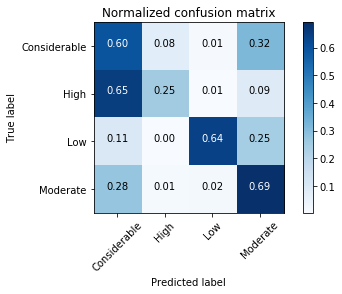

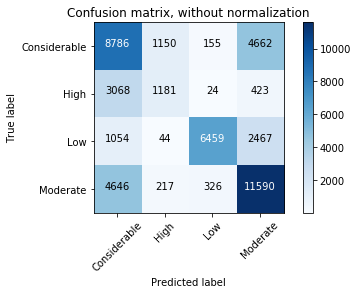

In [36]:
import matplotlib.pyplot as plt
error_evaluation.evaluateSingleClassShort(y_Above_test[yColumns[0]], resultAbove)
cnf_matrix = confusion_matrix(y_Above_test[yColumns[0]], resultAbove)
plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')

plt.figure()
error_evaluation.plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
evaluateSingleClassShort(y_Near_test['o_Day1DangerNearTreeline'], resultNear)

cnf_matrix = confusion_matrix(y_Near_test['o_Day1DangerNearTreeline'], resultNear)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
evaluateSingleClassShort(y_Below_test['o_Day1DangerBelowTreeline'], resultBelow)
cnf_matrix = confusion_matrix(y_Below_test['o_Day1DangerBelowTreeline'], resultBelow)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
#check out the feature importances
featureImportance = dict(zip(X_Above_train.columns, modelAbove.feature_importances_))
sortedFeatureImportance = sorted(featureImportance, key=featureImportance.get, reverse=True)

In [ ]:
sortedFeatureImportance[:100]

In [ ]:
#save the models
modelAbove._Booster.save_model("ModelAboveV1.bin")
modelNear._Booster.save_model("ModelNearV1.bin")
modelBelow._Booster.save_model("ModelBelowV1.bin")

In [ ]:
%%time #3 mins
# grid search
model = XGBClassifier(tree_method='gpu_hist')
learning_rate = [0.01]
n_estimators = [100, 200]
#max_depth = range(3,10,2)
#min_child_weight = range(1,6,2)
#gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, objective=["gpu:multi:softmax"])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=8, cv=kfold)
#(X_Near_train, y_Near_train[yNearColumn].values.ravel()
grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time #1 hour 30 mins
# grid search
model = XGBClassifier()
learning_rate = [0.01]
n_estimators = [100, 200]
#max_depth = range(3,10,2)
#min_child_weight = range(1,6,2)
#gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, objective=["multi:softmax"])
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=8, cv=kfold)
#(X_Near_train, y_Near_train[yNearColumn].values.ravel()
grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
%%time
# grid search
model = XGBClassifier(tree_method='gpu_hist')
learning_rate = [.1]
n_estimators = [400, 700, 900]
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma, objective=["gpu:multi:softmax"])
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", cv=kfold, verbose=20)
#(X_Near_train, y_Near_train[yNearColumn].values.ravel()
grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 7 folds for each of 180 candidates, totalling 1260 fits
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 
[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.43067055515189157, total=  21.0s
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.43092237396318045, total=  21.9s
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   48.3s remaining:    0.0s


[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.4249493529830228, total=  21.0s
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.42850439237430865, total=  20.2s
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.43170260531966864, total=  20.9s
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s


[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.423006056386163, total=  21.0s
[CV] n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.4min remaining:    0.0s


[CV]  n_estimators=400, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1, score=-0.42782897282104515, total=  20.6s
[CV] n_estimators=700, gamma=0.0, learning_rate=0.1, max_depth=3, objective=gpu:multi:softmax, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.8min remaining:    0.0s
